### 2d Experiment using RCPS \& Proto-RCPS
- Create multivariate gaussian mixture:

$$
\mathcal{D} = 

\frac{1}{3}
\mathcal{N}([0,0]^T, \begin{bmatrix}
1 & 0 \\
0 & 1 
\end{bmatrix}) 
+

\frac{1}{3}
\mathcal{N}([3,3]^T, \begin{bmatrix}
0.5 & 0.2 \\
0.2 & 0.5 
\end{bmatrix}) 
+

\frac{1}{3}
\mathcal{N}([-3,-4]^T, \begin{bmatrix}
0.7 & -0.2 \\
-0.2 & 0.7 
\end{bmatrix}) 
$$

- $30.000$ Samples
- **RCPS**: $50 \times 50 = 2500$ bin centers. $X \in \{-7,7\}$ , $Y \in \{-7, 7\}$
- **RCPS-Proto**: $50 \times 50 = 2500$ prototypes initialized at $X \in \{-7,7\}$ , $Y \in \{-7, 7\}$
#
- Issues-1: Predicted output probabilities do not correspond to correct probabilities. Have to adjust according to the region of each prototype.
- Issues-2: Many Unused Prototypes exist.
 
- Edited by Halil for calculating conformal prediction and covarage 
- Tried new losses for to improve model 


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection

from scipy.stats import multivariate_normal
from scipy.spatial import Voronoi, voronoi_plot_2d

import torch
import torch.nn as nn
import torch.nn.functional as F

from time import sleep
from IPython.display import clear_output


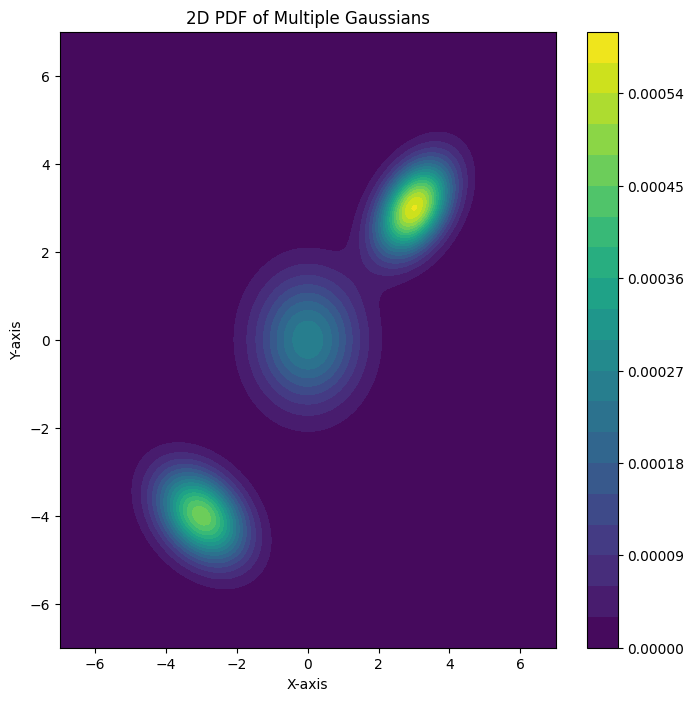

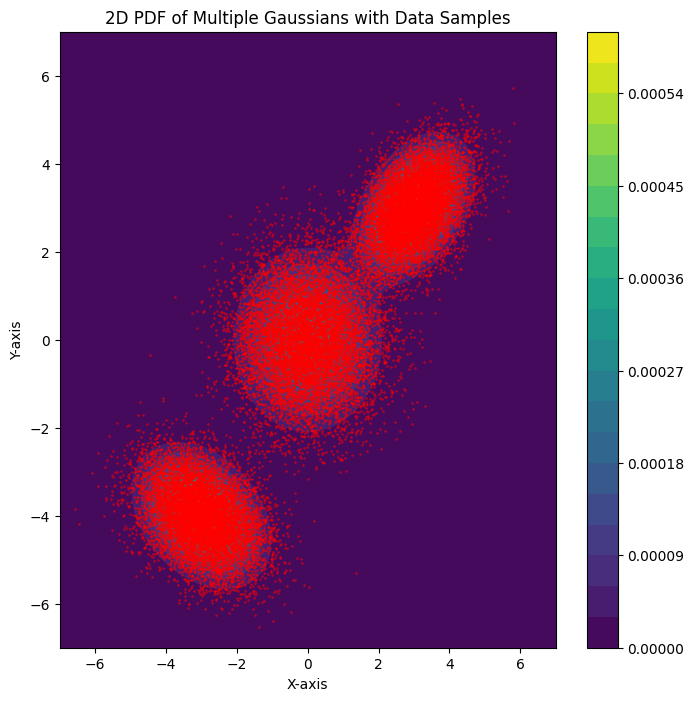

In [2]:
np.random.seed(0)

# Centers of the Gaussians
means = [(0, 0), 
         (3, 3), 
         (-3, -4)]  
# Covariance matrices
covariances = [ [[1, 0], 
                 [0, 1]], 
               [[0.5, 0.2], 
                [0.2, 0.5]], 
               [[0.7, -0.2], 
                [-0.2, 0.5]] ] 
# Number of data samples
sizes = [10000,
         10000,
         10000]

# Grid space (-7,7)x(-7,7)
x = np.linspace(-7, 7, 200)
y = np.linspace(-7, 7, 200)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))

# Create the combined Gaussian distribution
Z = np.zeros(X.shape)
data_samples = []
for mean, cov, size in zip(means, covariances, sizes):
    # Generate data samples from the Gaussian
    rv = np.random.multivariate_normal(mean, cov, size=size)
    data_samples.append(rv)
    
    # Add the Gaussian PDF contribution to the grid
    rv_pdf = multivariate_normal(mean, cov).pdf(pos)
    # Z += np.exp(-0.5 * (np.sum(np.dot(pos - mean, np.linalg.inv(cov)) * (pos - mean), axis=2))) * np.linalg.det(cov)**(-1/2) * size
    Z += rv_pdf * size  # Weight by the number of samples for each distribution

data_samples = np.vstack(data_samples)

# Normalize the combined distribution
Z /= np.sum(Z)

# Plot the 2D PDF
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()

# Plot the 2D PDF with data samples
plt.figure(figsize=(8, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar()
plt.scatter(data_samples[:,0], data_samples[:,1], c='r', s=1, marker='x', alpha=0.5)
plt.title('2D PDF of Multiple Gaussians with Data Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


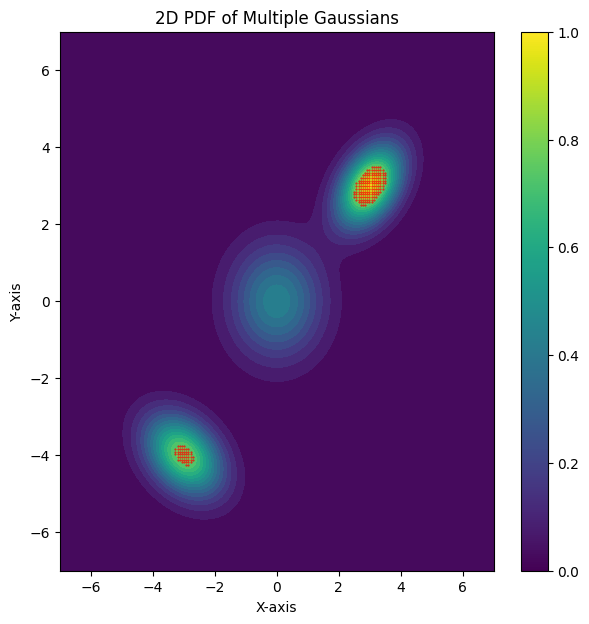

In [3]:
# Flatten the Z array and sort it in descending order
Z_flat = Z.flatten()
sorted_indices = np.argsort(Z_flat)[::-1]
sorted_Z = Z_flat[sorted_indices]

# Calculate the cumulative sum and find the threshold index
cumulative_sum = np.cumsum(sorted_Z)
threshold_index = np.where(cumulative_sum >= 0.1)[0][0]

# Get the x, y coordinates for the corresponding indices
top_indices = sorted_indices[:threshold_index+1]
top_x = X.flatten()[top_indices]
top_y = Y.flatten()[top_indices]

plt.figure(figsize=(7, 7))
# Plot the 2D PDF
plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.scatter(top_x, top_y, c='red',s=0.2)
plt.colorbar()
plt.title('2D PDF of Multiple Gaussians')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()


In [4]:
top_x.shape

(204,)

In [5]:
((X[0,1] - X[0,0]) ** 2) * 204

1.0096714729425922

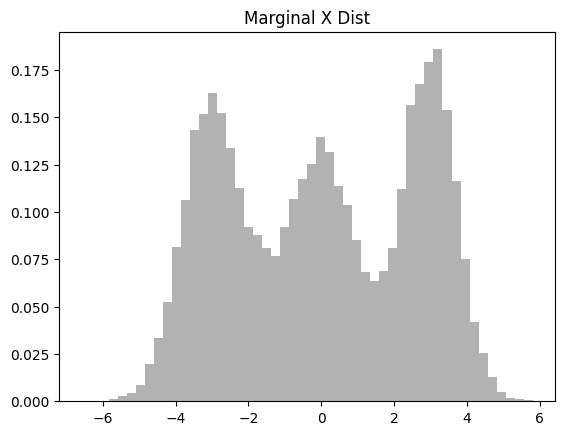

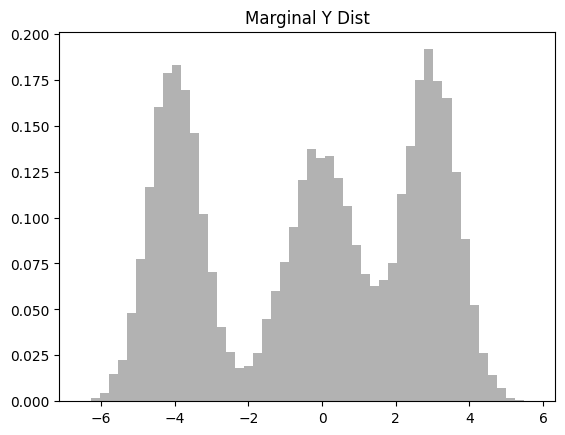

In [6]:
# Get X Centers
plt.figure()
plt.title("Marginal X Dist")
X_bin_count = 50
X_hist = plt.hist(data_samples[:,0], bins=X_bin_count, density=True, alpha=0.6, color='gray', label='Data')
X_digital_labels = np.fmin(np.digitize(data_samples[:,0], X_hist[1]), X_bin_count)

# Get Y Centers
plt.figure()
plt.title("Marginal Y Dist")
Y_bin_count = 50
Y_hist = plt.hist(data_samples[:,1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', label='Data')
Y_digital_labels = np.fmin(np.digitize(data_samples[:,1], Y_hist[1]), Y_bin_count)

digital_labels = ((X_digital_labels-1) + (Y_digital_labels-1) * Y_bin_count)

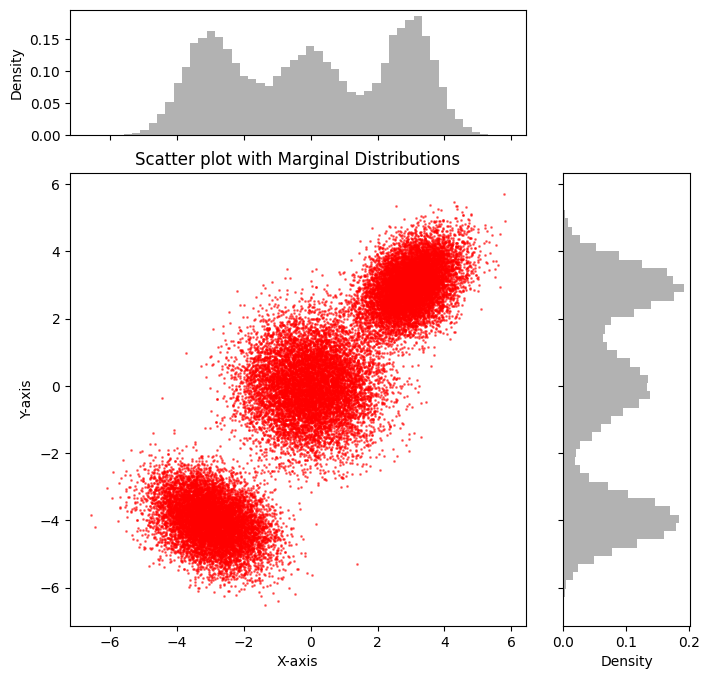

In [7]:
# Create a figure with a main plot area and two marginal histograms
from matplotlib import gridspec

# Set up the figure with specified size and gridspec
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4, hspace=0.3, wspace=0.3)

# Main scatter plot
ax_main = fig.add_subplot(gs[1:4, 0:3])
ax_main.scatter(data_samples[:, 0], data_samples[:, 1], c='r', s=1, alpha=0.5)
ax_main.set_xlabel('X-axis')
ax_main.set_ylabel('Y-axis')
ax_main.set_title('Scatter plot with Marginal Distributions')

# Marginal histogram for X
ax_histx = fig.add_subplot(gs[0, 0:3], sharex=ax_main)
ax_histx.hist(data_samples[:, 0], bins=X_bin_count, density=True, alpha=0.6, color='gray')
ax_histx.set_ylabel('Density')
ax_histx.tick_params(axis='x', labelbottom=False)  # Hide x labels for top histogram

# Marginal histogram for Y
ax_histy = fig.add_subplot(gs[1:4, 3], sharey=ax_main)
ax_histy.hist(data_samples[:, 1], bins=Y_bin_count, density=True, alpha=0.6, color='gray', orientation='horizontal')
ax_histy.set_xlabel('Density')
ax_histy.tick_params(axis='y', labelleft=False)  # Hide y labels for right histogram

plt.show()


In [8]:
def get_cuda_summary(memory=False):
    import torch

    if torch.cuda.is_available():
        print('CUDA device = ', torch.cuda.get_device_name())
        print('Available number of devices = ', torch.cuda.device_count())
        print('Device numbers              = ', list(range(torch.cuda.device_count())))
        print('Current device              = ', torch.cuda.current_device())
        if memory:
            print(torch.cuda.memory_summary())
    else:
        print('cuda is not available')

import torch
get_cuda_summary()
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.set_device(0) if torch.cuda.is_available() else None
device = "cuda:1"

CUDA device =  NVIDIA GeForce GTX 1080 Ti
Available number of devices =  4
Device numbers              =  [0, 1, 2, 3]
Current device              =  0


In [9]:
class UnconditionalClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=50*50):
        super(UnconditionalClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.no_of_classes),
        )
        
    def forward(self, x):
        x = self.net(x)
        return x

In [10]:
digital_labels.shape

(30000,)

In [11]:
Y =torch.from_numpy((digital_labels).reshape(-1)).to(device)
X = torch.zeros_like(Y).reshape(-1,1).float().to(device)

# split the data
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)
test_x, cal_x, test_y, cal_y = train_test_split(test_x, test_y, test_size=0.5, random_state=42)



model = UnconditionalClassifier().to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

In [12]:
losses = []
torch.manual_seed(0)
for step in range(500):
    model.train()
    #yq1, yq2, yq3 = model(x)
    #loss = criterion(input=(yq1, yq2, yq3), target=y)
    logits = model(train_x)
    loss = criterion(logits, train_y)
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 100 == 0):
        """
        Show your intermediate results
        """
        print('epoch {} loss={:.4}'.format(step+1, loss.data.item()))
        pass

epoch 1 loss=7.826
epoch 100 loss=6.251
epoch 200 loss=6.241
epoch 300 loss=6.239
epoch 400 loss=6.239
epoch 500 loss=6.238


In [13]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

In [14]:
import torch
import numpy as np
import torch.nn.functional as F

# yüzde kaç covarage istiyoz 
alpha = 0.9

model.eval()
with torch.no_grad():
    cal_logits = model(cal_x)
    cal_probs = F.softmax(cal_logits, dim=1)
    true_class_probs = [cal_probs[i,cal_y[i]].cpu().item() for i in range(cal_probs.size(0))] 
    true_class_probs = np.array(true_class_probs)
    # sort 
    sorted_true_class_probs = np.sort(true_class_probs)
    p_score = np.quantile(sorted_true_class_probs, 1-alpha)

covarage = 0.891
pinaw = 28.141286200530107


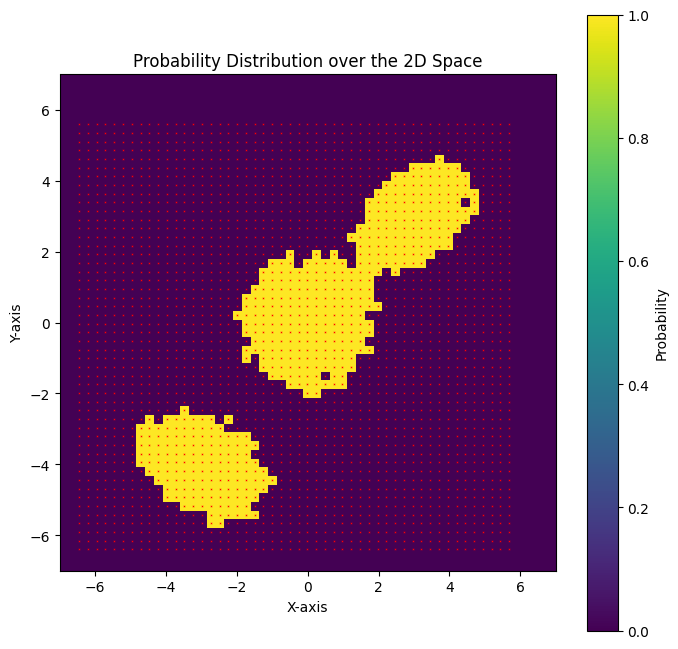

In [15]:
# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
# calculate_covarage
output_probs = torch.softmax(output_logits, dim=1).squeeze(0).cpu().numpy()
output_probs[output_probs > p_score] = 1
output_probs[output_probs < p_score] = 0


number_of_true = 0
for true_class in test_y:
    number_of_true += output_probs[true_class]
        
# covarage = number_of_true / all sample number 

covarage = number_of_true / test_y.size(0)


output_probs_grid = output_probs.reshape(50, 50)

# how many of the goes in the area 


# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

print(f"covarage = {covarage}") 
one_square_area = (x_edges - np.roll(x_edges,1))[1] * (y_edges - np.roll(y_edges,1))[1]
pinaw = (output_probs == 1).sum() * one_square_area
print(f"pinaw = {pinaw}")

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

# Get the colormap and set the color for under 0 values
cmap = plt.get_cmap('viridis')

# Set vmin to 0 to make sure the zero probability regions are colored
im = ax.imshow(output_probs_grid, extent=(x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]), 
               origin='lower', cmap=cmap, vmin=0, vmax=output_probs_grid.max())

# Set the facecolor of the axes to the color corresponding to the lowest value in the colormap
ax.set_facecolor(cmap(0))  # This sets the background to the same color as the lowest probability

# Set the xlim and ylim with no extra background
plt.xlim(-7, 7)
plt.ylim(-7, 7)

# Add the colorbar and labels
plt.colorbar(im, ax=ax, label='Probability')
plt.title('Probability Distribution over the 2D Space')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Display proto centers
xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
plt.scatter(xx.flatten(), yy.flatten(), marker='x', c='red', s=0.1)
plt.show()


In [16]:
one_square_area = (x_edges - np.roll(x_edges,1))[1] * (y_edges - np.roll(y_edges,1))[1]

pinaw = (output_probs == 1).sum() * one_square_area



In [17]:
output_probs_grid.sum() * one_square_area

28.141286200530107

In [18]:
######### PROTOTYPE 1 ####################33

In [19]:
class UnconditionalProtoClassifier(nn.Module):
    def __init__(self, in_size = 1, no_of_classes=50*50):
        super(UnconditionalProtoClassifier, self).__init__()
        self.in_size = in_size
        self.no_of_classes = no_of_classes
        self.hidden_size = 256
        self.net = nn.Sequential(
            nn.Linear(self.in_size, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size),
            nn.ReLU(),
        )
        self.fc = nn.Linear(self.hidden_size, self.no_of_classes)
        
    def forward(self, x):
        x = self.net(x)
        x = self.fc(x)
        return x

In [34]:
def distance_based_ce(logits, cdist):
    # take softmax of the cdists
    probs = F.softmax(logits, dim=1)
    return (cdist.detach() * probs).sum(dim=1).mean()


def distance_based_labeling(cdist,logits):
    # take softmax of the cdists
    cdist_probs = F.softmax(-cdist, dim=1)
    
    probs = F.softmax(logits, dim=1)
    
    return F.kl_div(probs, cdist_probs, reduction='batchmean')


def entropy_loss(logits):
    probs = F.softmax(logits, dim=1)
    log_probs = F.log_softmax(logits, dim=1)  # Use log_softmax for numerical stability
    return - torch.sum(probs * log_probs, dim=1).mean()


In [35]:
def moving_average(a, n=2):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n
X_bin_centers = moving_average(X_hist[1])
Y_bin_centers = moving_average(Y_hist[1])

xx, yy = np.meshgrid(X_bin_centers, Y_bin_centers)
cluster_coordinates = np.array(list(zip(xx.flatten(), yy.flatten()))).shape

initial_prototypes = np.stack([xx.flatten(), yy.flatten()], axis=1)

# CROSS ENTROPY LOSS
protos = nn.Parameter(torch.Tensor(initial_prototypes).to(device) ,requires_grad=True)
# protos = nn.Parameter(torch.Tensor(torch.randn((500,2))* 5).to(device) ,requires_grad=True)
# CROSS ENTROPY LOSS

Y = torch.from_numpy(data_samples).to(torch.float32).to(device)
X = torch.zeros(Y.size(0)).reshape(-1,1).float().to(device)
# split the data
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=42)
test_x, cal_x, test_y, cal_y = train_test_split(test_x, test_y, test_size=0.5, random_state=42)


model = UnconditionalProtoClassifier(no_of_classes = len(protos)).to(device)
# criterion = nn.CrossEntropyLoss()
criterion = distance_based_ce

optimizer = torch.optim.Adam(params=list(model.parameters())+ [protos], lr=0.05)


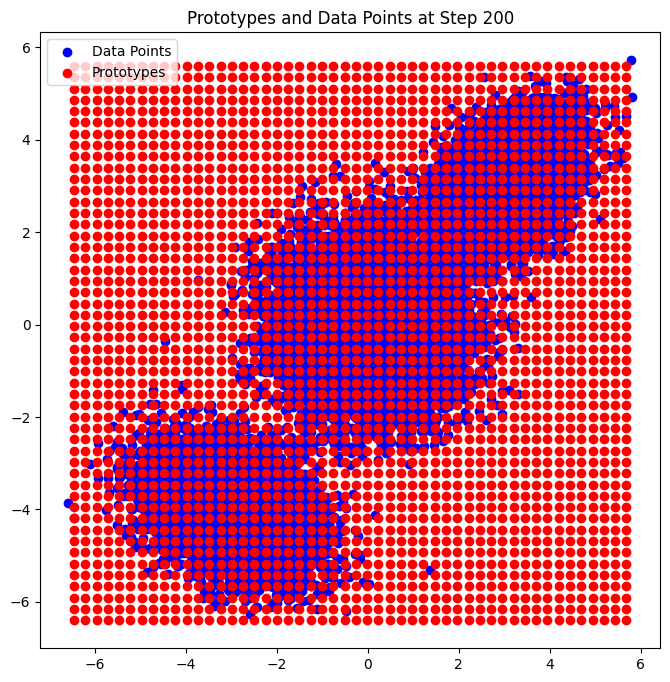

epoch 200, loss=3.605, CE_Loss: 3.604957342147827, MinDist_Loss: 0.0


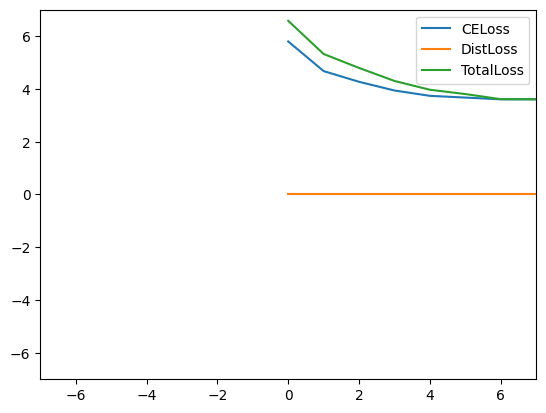

In [36]:
ce_losses = []
mindist_losses = []
torch.manual_seed(0)
losses = []
for step in range(200):
    # Visualization
    with torch.no_grad():
        protos.clamp_(-7, 7)
    if (step==0) or ((step+1) % 10 == 0):
        sleep(0.1)
        clear_output(wait=True)
        # Visualize protos
        plt.figure(figsize=(8, 8))
        plt.scatter(train_y.cpu().numpy()[:, 0], train_y.cpu().numpy()[:, 1], c='blue', label='Data Points')
        plt.scatter(protos.detach().cpu().numpy()[:, 0], protos.detach().cpu().numpy()[:, 1], c='red', label='Prototypes')
        plt.title(f'Prototypes and Data Points at Step {step+1}')
        plt.legend()
        plt.show()
    # # Clear unused protos
    # if (step!=0) and ((step+1) % 20 == 0):
    #     with torch.no_grad():
    #         logits = model(train_x)
                
    #         cdist_list = torch.cdist(train_y, protos, p=2)
    #         mindist, pos = torch.min(cdist_list, dim=1)
            
    #         prototype_usage = torch.bincount(pos, minlength=protos.size(0)).detach()
    #         active_prototypes = torch.where(prototype_usage > 0)[0]
    #         model.fc.weight = torch.nn.parameter.Parameter(torch.index_select(model.fc.weight, dim=0, index=active_prototypes), requires_grad=True)
    #         model.fc.bias = torch.nn.parameter.Parameter(torch.index_select(model.fc.bias, dim=0, index=active_prototypes), requires_grad=True)
    #         protos = torch.nn.parameter.Parameter(torch.index_select(protos, dim=0, index=active_prototypes), requires_grad=True)
    #     optimizer = torch.optim.Adam(params=list(model.parameters())+ [protos], lr=0.05)

    model.train()
    optimizer.zero_grad()
    logits = model(train_x)
    
    cdist_list = torch.cdist(train_y, protos, p=2)
    mindist, pos = torch.min(cdist_list, dim=1)
    
    lambda_fact = 0.0
    # ce_loss = criterion(logits, pos)
    mindist_loss = lambda_fact * torch.mean(mindist)
    
    ce_loss = distance_based_ce(logits, cdist_list.detach())
    # protos2protos_dist = 0.2 * (-torch.cdist(protos, protos, p=2).topk(k=2, dim=1, largest=False).values.mean())
    loss = ce_loss + mindist_loss + 0.1 * entropy_loss(logits)

    ce_losses.append(ce_loss.data.item())
    mindist_losses.append(mindist_loss.data.item())
    losses.append(loss.data.item())
    #print(yqs.shape, train_y_tr.shape)
    loss.backward()
    optimizer.step()

    if (step==0) or ((step+1) % 10 == 0):
        print(f'epoch {step+1}, loss={loss.data.item():.4}, CE_Loss: {ce_loss.data.item()}, MinDist_Loss: {mindist_loss.data.item()}')

plt.xlim(-7,7)
plt.ylim(-7,7)

plt.plot(ce_losses, label='CELoss')
plt.plot(mindist_losses, label='DistLoss')
plt.plot(losses, label='TotalLoss')
plt.legend()

In [30]:
output_probs_flat.shape

NameError: name 'output_probs_flat' is not defined

In [222]:
output_probs_flat.mean(), output_probs_flat.std(), output_probs_flat.max(), output_probs_flat.min(), 

(0.00083194673, 0.028831486, 1.0, 0.0)

In [223]:
adjusted_probs.numpy().mean(), adjusted_probs.numpy().std(), adjusted_probs.numpy().max(), adjusted_probs.numpy().min(), 

# adjusted_probs.numpy().max()

(0.0008319467554076539, 0.028831486607260478, 0.9999999999884698, 0.0)

Coverage of the data by the top Voronoi regions: 100.00%
PINAW Score: inf


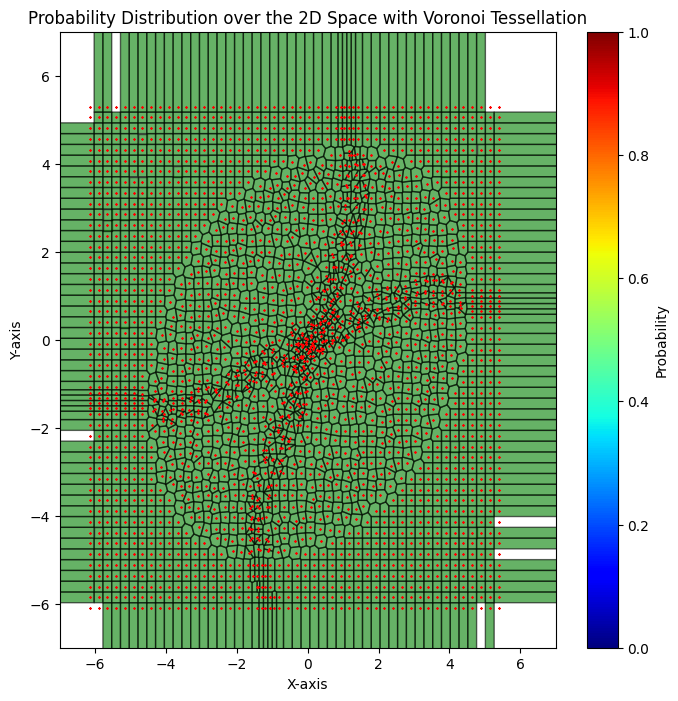

In [224]:


# Ensure the model is in evaluation mode
model.eval()

# Feed the input tensor with value 0
input_tensor = torch.zeros(1, 1).to(device)  # Batch size of 1, input size of 1

# Generate model predictions
with torch.no_grad():  # Disable gradient calculation for inference
    output_logits = model(input_tensor)

# Apply softmax to get the probability distribution over the output classes
output_probs = torch.softmax(output_logits, dim=1).cpu().numpy()


output_probs_flat = output_probs.flatten()

# Use the pre-computed bin edges for X and Y (X_hist[1] and Y_hist[1])
x_edges = X_hist[1]  # Assuming X_hist[1] contains the bin edges for X
y_edges = Y_hist[1]  # Assuming Y_hist[1] contains the bin edges for Y

# Flatten the output probabilities to match with the prototypes
flat_probs = output_probs.flatten()

# Display prototype centers
proto_centers = protos.detach().cpu().numpy()

# Perform Voronoi tessellation
vor = Voronoi(proto_centers)

def polygon_area(vertices):
    vertices = np.array(vertices)
    """Calculate the area of a polygon using the Shoelace theorem."""
    x = vertices[:, 0]
    y = vertices[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# Plot the probability distribution over the 2D grid using the bin edges
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)  # nrows, ncols, index

highlight_color = 'green'  # Color for top_indices regions

# Create the colormap for other regions
cmap = plt.get_cmap('jet')
norm = plt.Normalize(vmin=flat_probs.min(), vmax=flat_probs.max())

regions = []
region_areas = []

# Loop through each prototype and its corresponding Voronoi region
for i, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    
    # Only include finite Voronoi regions (no infinite vertices, i.e., no '-1' in region)
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[j] for j in region]
        regions.append(polygon)
        area = polygon_area(polygon)
        region_areas.append(area)
    else:
        region_areas.append(float('inf'))  # For infinite regions, you can assign infinity or another placeholder

adjusted_probs = output_probs_flat / region_areas
adjusted_probs = adjusted_probs/adjusted_probs.sum()

sorted_indices = np.argsort(adjusted_probs)[::-1]
sorted_output_probs = adjusted_probs[sorted_indices]

import torch
import numpy as np
import torch.nn.functional as F

# yüzde kaç covarage istiyoz 
alpha = 0.1

model.eval()
with torch.no_grad():
    cal_logits = model(cal_x)
    cal_probs = F.softmax(cal_logits, dim=1)
   
    adjusted_probs = cal_probs.cpu() / torch.tensor(region_areas).unsqueeze(0)
    adjusted_probs = adjusted_probs/adjusted_probs.sum(keepdim=True, dim=1)
    
    cdist_list = torch.cdist(cal_y, protos, p=2)
    mindist, pos = torch.min(cdist_list, dim=1)
    
    true_class_probs = [adjusted_probs[i,pos[i]].cpu().item() for i in range(adjusted_probs.size(0))] 
    true_class_probs = np.array(true_class_probs)
    # sort 
    sorted_true_class_probs = np.sort(true_class_probs)
    p_score = np.quantile(sorted_true_class_probs, 1-alpha)
# threshold_index = np.where(cumulative_sum >= p_score)[0][0]
threshold_index = np.where(sorted_output_probs >= p_score)
top_indices = sorted_indices[threshold_index]


from scipy.spatial import distance
# Move test_y to CPU and convert to numpy if it's a PyTorch tensor
if isinstance(test_y, torch.Tensor):
    test_y = test_y.cpu().numpy()

assigned_regions = []
for point in test_y:  # Assuming test_y is a 2D array or list of points
    distances = distance.cdist([point], proto_centers)  # Calculate distance to all prototype centers
    nearest_proto_index = np.argmin(distances)
    assigned_regions.append(nearest_proto_index)

# The rest of the code remains the same
top_region_data_count = 0
total_data_count = len(test_y)

for assigned_region in assigned_regions:
    if assigned_region in top_indices:
        top_region_data_count += 1

coverage_percentage = (top_region_data_count / total_data_count) * 100

print(f"Coverage of the data by the top Voronoi regions: {coverage_percentage:.2f}%")
pinaw_score = np.array(region_areas)[top_indices].sum() 
print(f"PINAW Score: {pinaw_score:.5f}")

colors = []
for i, region_index in enumerate(vor.point_region):
    region = vor.regions[region_index]
    if not -1 in region and len(region) > 0:
        polygon = [vor.vertices[j] for j in region]
        # colors.append(cmap(norm(adjusted_probs[i])))
        if i in top_indices:
            colors.append(highlight_color)  # Use the highlight color for top regions
        else:
            colors.append(cmap(0))


# Create a PolyCollection for Voronoi regions
voronoi_region_collection = PolyCollection(regions, facecolors=colors, edgecolors='k', alpha=0.6)
ax.add_collection(voronoi_region_collection)

# Plot prototype centers
ax.scatter(proto_centers[:, 0], proto_centers[:, 1], marker='x', c='red', s=1)

# Set the axis limits and labels
plt.xlim(-7, 7)
plt.ylim(-7, 7)
plt.title('Probability Distribution over the 2D Space with Voronoi Tessellation')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax, label='Probability')

plt.show()


In [82]:
pinaw_score = np.array(region_areas)[top_indices].sum() 
print(pinaw_score)

27.626171641006266


In [61]:
adjusted_probs.sum()

1.0

In [82]:
adjusted_probs.argsort()

1

In [62]:
len(protos)

1096